In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

In [2]:
env = BlackjackEnv()

In [3]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        alpha: learning rate
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    # Implement this!
    for i_episode in range(1,num_episodes+1):
        
        if i_episode % 1000 == 0:
            #print "\rEpisode %d/%d" % (i_episode, num_episodes)
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end = "")
            sys.stdout.flush()
        
        # 获取state,action,reward序列
        state = env.reset()  # s_t,a_t,r_t,s_{t+1},a_{t+1},r_{t+1}
        series = []
        for t in range(100):
            action = np.argmax(policy(state))
            next_state, reward, done, _ = env.step(action)
            series.append((state, action, reward))
            if done:
                break
            state = next_state    
     
        for state in set([x[0] for x in series]):
            first_index = next(i for i,x in enumerate(series) if x[0] == state) # 找到第一次出现
            # 从第一次出现起，计算discount reward
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(series[first_index:])])
            returns_sum[state] += G
            returns_count[state] += 1
            
    for state, reward in returns_sum.items():
        V[state] = returns_sum[state] / returns_count[state]

    return V    

In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return np.array([1.0, 0.0]) if score >= 20 else np.array([0.0, 1.0])

Episode 10000/10000.

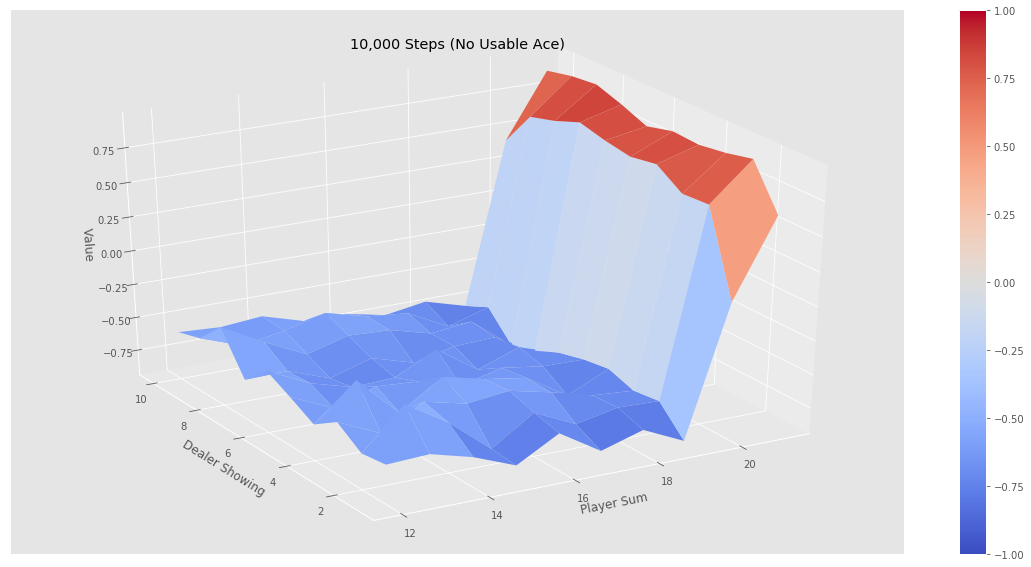

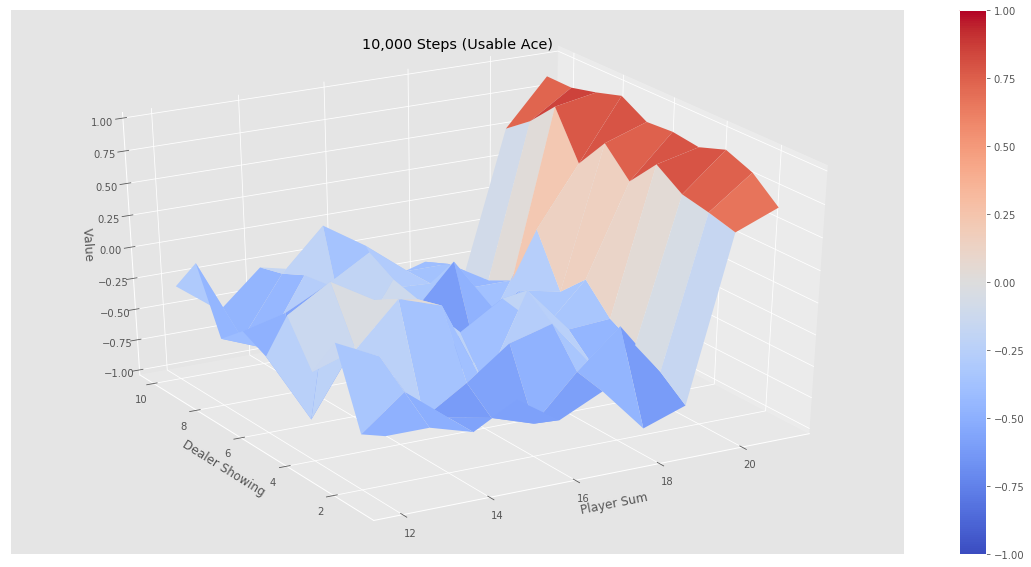

Episode 500000/500000.

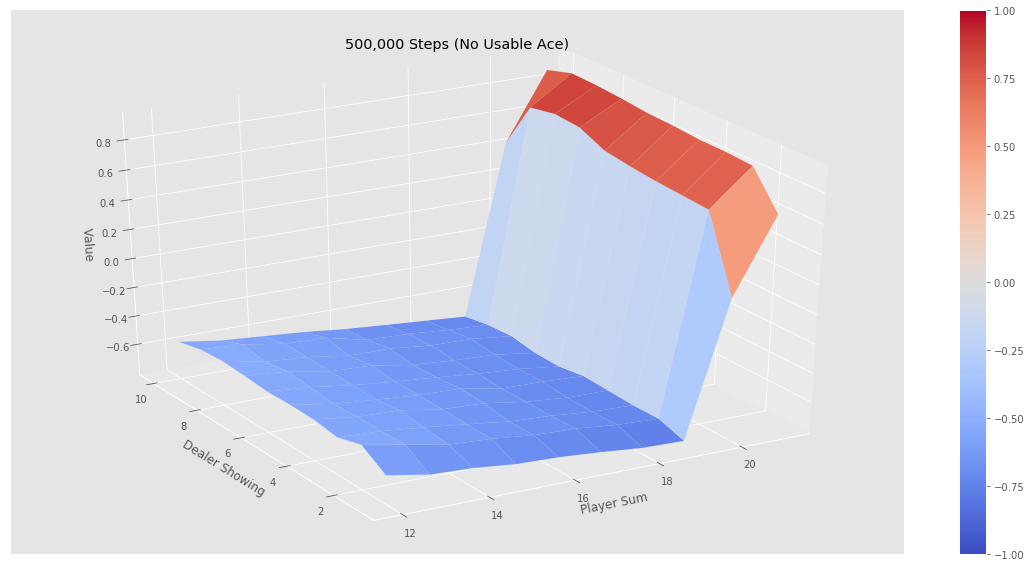

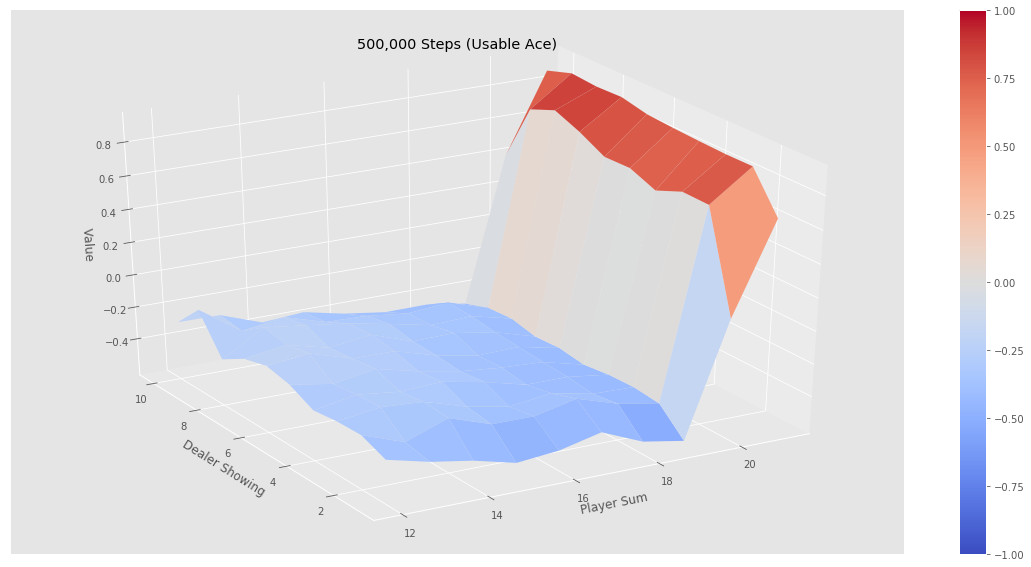

In [5]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")